# Bank Project - Resampling

In [72]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
import preprocessing as prep
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV


from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from matplotlib.pyplot import cm
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## Fetch Data

In [10]:
df = pd.read_csv('./data/bank-full.csv', sep=';')

In [11]:
ct = ColumnTransformer(
    [("target",prep.TargetTransformer(),'y')])

y_trans = pd.DataFrame(data = ct.fit_transform(df),columns=['y_trans'] ,index = df.index)

df_t = pd.concat([y_trans,df],axis=1).drop(['y'],axis=1)

In [12]:
# hold-out set

df_holdout = df_t.sample(1000, random_state = 101)
df_t = df_t.loc[~df_t.index.isin(df_holdout.index)]

## Downsampling & Upsampling

In [13]:
# Upsample minority classPython

# Separate majority and minority classes
df_majority = df_t[df_t.y_trans==0]
df_minority = df_t[df_t.y_trans==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=1)
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Downsample majority class
df_majority_downsampled = resample(df_majority, replace=False,n_samples=len(df_minority),random_state=101)

# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])

In [14]:
cat_features = ['job','marital','education','default','housing','loan','contact','poutcome','month']

ct = ColumnTransformer(
    [
    ("logplus1",prep.LogPlus1Transformer(),['duration','age']),
    ("campaign",prep.CampaignTransformer(),'campaign'),
    ("balance",prep.CampaignTransformer(),'balance'),
    ('ohe',OneHotEncoder(sparse=False),cat_features)
    ]
    )

# No Sampling Strategy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_t.drop(['y_trans'],axis=1), df_t.y_trans, stratify = df_t.y_trans, random_state = 101, test_size=0.25)

In [ ]:
rtree = RandomForestClassifier()
dtree = DecisionTreeClassifier()
lreg = LogisticRegression()
nbayes = GaussianNB()

rtree.fit(ct.fit_transform(X_train),y_train)
dtree.fit(ct.fit_transform(X_train),y_train)
lreg.fit(ct.fit_transform(X_train),y_train)
nbayes.fit(ct.fit_transform(X_train),y_train)

In [ ]:
plt.figure(figsize=(10,5))
color=iter(cm.rainbow(np.linspace(0,1,4)))
model_dict = {'NaiveBayes':nbayes, 'LogisticRegression':lreg, 'DecisionTreeClassifier':dtree, 'RandomForestClassifier':rtree}

for model in model_dict.keys():
    y_score = model_dict[model].predict_proba(ct.fit_transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color = next(color), label=model + ': %0.2f' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Under-sampling Strategy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_downsampled.drop(['y_trans'],axis=1), df_downsampled.y_trans, stratify = df_downsampled.y_trans, random_state = 101, test_size = 0.25)

In [ ]:
rtree = RandomForestClassifier()
dtree = DecisionTreeClassifier()
lreg = LogisticRegression()
nbayes = GaussianNB()

rtree.fit(ct.fit_transform(X_train),y_train)
dtree.fit(ct.fit_transform(X_train),y_train)
lreg.fit(ct.fit_transform(X_train),y_train)
nbayes.fit(ct.fit_transform(X_train),y_train)

In [ ]:
plt.figure(figsize=(10,5))

color=iter(cm.rainbow(np.linspace(0,1,4)))
model_dict = {'NaiveBayes':nbayes, 'LogisticRegression':lreg, 'DecisionTreeClassifier':dtree, 'RandomForestClassifier':rtree}

for model in model_dict.keys():
    y_score = model_dict[model].predict_proba(ct.fit_transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color = next(color), label=model + ': %0.2f' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves\n Downsampling')
plt.legend(loc="lower right")
plt.show()

# Over-sampling Strategy

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled.drop(['y_trans'],axis=1), df_upsampled.y_trans, stratify = df_upsampled.y_trans, random_state = 101, test_size = 0.25)

NameError: name 'df_upsampled' is not defined

In [ ]:
rtree = RandomForestClassifier()
dtree = DecisionTreeClassifier()
lreg = LogisticRegression()
nbayes = GaussianNB()

rtree.fit(ct.fit_transform(X_train),y_train)
dtree.fit(ct.fit_transform(X_train),y_train)
lreg.fit(ct.fit_transform(X_train),y_train)
nbayes.fit(ct.fit_transform(X_train),y_train)

In [ ]:
plt.figure(figsize=(10,5))

color=iter(cm.rainbow(np.linspace(0,1,4)))
model_dict = {'NaiveBayes':nbayes,'LogisticRegression':lreg,'DecisionTreeClassifier':dtree,'RandomForestClassifier':rtree}

for model in model_dict.keys():
    y_score = model_dict[model].predict_proba(ct.fit_transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color = next(color), label=model + ': %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves\nUpsampling')
plt.legend(loc="lower right")
plt.show()

# SMOTE Strategy

In [70]:
#!pip install imblearn

In [78]:
sm = SMOTE(sampling_strategy = 0.5, random_state=101)

X_train, X_test, y_train, y_test = train_test_split(df_t.drop(['y_trans'],axis=1), df_t.y_trans, stratify = df_t.y_trans, random_state = 101, test_size = 0.25)

X_res, y_res = sm.fit_resample(ct.fit_transform(X_train), y_train)
rtree = RandomForestClassifier(class_weight='balanced')
rtree_params = {'n_estimators':[5,10,15,20], 'min_samples_split':[2,5,10,20], 'min_samples_leaf':[5, 10, 20, 25]}
clf = GridSearchCV(rtree, cv=5, param_grid = rtree_params, scoring=prec_scorer)
clf.fit(X_res, y_res)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=101)
scores = cross_val_score(clf.best_estimator_, X_res, y_res, scoring=prec_scorer, cv=cv)
scores

array([0.80877088, 0.81478102, 0.80339589, 0.80254589, 0.82026944,
       0.7984473 , 0.79946524, 0.81932131, 0.81535207, 0.80945303,
       0.81089259, 0.81961737, 0.8075653 , 0.81010401, 0.81360049])

In [79]:
pd.DataFrame(data = np.stack([clf.cv_results_['params'],clf.cv_results_['mean_test_score']],axis=1), columns = ['parameters','precision']).sort_values(by='precision',ascending=False).head()

,parameters,precision
10,"{'min_samples_leaf': 5, 'min_samples_split': 1...",0.812851
7,"{'min_samples_leaf': 5, 'min_samples_split': 5...",0.812213
3,"{'min_samples_leaf': 5, 'min_samples_split': 2...",0.811905
11,"{'min_samples_leaf': 5, 'min_samples_split': 1...",0.810597
5,"{'min_samples_leaf': 5, 'min_samples_split': 5...",0.809968


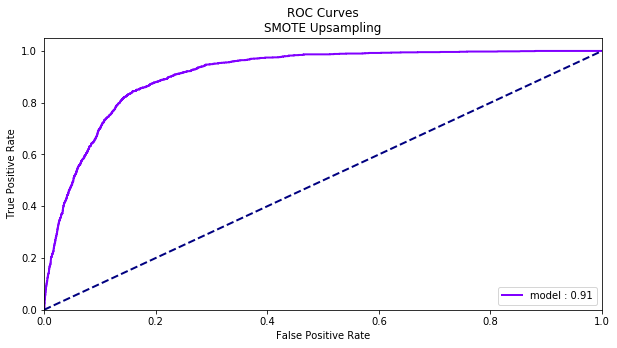

In [82]:
plt.figure(figsize=(10,5))

color=iter(cm.rainbow(np.linspace(0,1,4)))

y_score = clf.best_estimator_.predict_proba(ct.fit_transform(X_test))
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color = next(color), label='model ' + ': %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves\nSMOTE Upsampling')
plt.legend(loc="lower right")
plt.show()